# Standardizing data

Some models, like K-nearest neighbors (KNN) & neural networks, work better with scaled data -- so we'll standardize our data.

In [1]:
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from pandas_datareader import DataReader
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [9,8]

In [2]:
ticker = 'ITSA4.SA'
data_source = 'yahoo'
start = datetime(2016, 1, 1)
end = datetime(2019,12, 31)

itau = DataReader(ticker,data_source, start, end)
itau = itau.sort_values(by='Date')
itau.drop(columns=['High','Low', 'Open', 'Close'], inplace=True)
itau.loc[itau['Volume'] == 0, 'Volume'] = (itau['Volume'].shift(-1) + itau['Volume'].shift(1))/2

In [3]:
# Create 5-day % changes of Adj_Close for the current day, and 5 days in the future
itau['5d_future_close'] = itau['Adj Close'].shift(-5)
itau['5d_close_future_pct'] = itau['5d_future_close'].pct_change(5)
itau['5d_close_pct'] = itau['Adj Close'].pct_change(5)

In [4]:
import talib

feature_names = ['5d_close_pct']  # a list of the feature names for later

# Create moving averages and rsi for timeperiods of 14, 30, 50, and 200
for n in [14,30,50,200]:

    # Create the moving average indicator and divide by Adj_Close
    itau['ma' + str(n)] = talib.SMA(itau['Adj Close'].values,
                              timeperiod=n) / itau['Adj Close']
    # Create the RSI indicator
    itau['rsi' + str(n)] = talib.RSI(itau['Adj Close'].values, timeperiod=n)
    
    # Add rsi and moving average to the feature name list
    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]

In [5]:
# Create 2 new volume features, 1-day % change and 5-day SMA of the % change
new_features = ['Adj_Volume_1d_change', 'Adj_Volume_1d_change_SMA']
feature_names.extend(new_features)
itau['Adj_Volume_1d_change'] = itau['Volume'].pct_change()
itau['Adj_Volume_1d_change_SMA'] = talib.SMA(itau['Adj_Volume_1d_change'].values,
                        timeperiod=5)
itau = itau.dropna()

In [6]:
# Create a size for the training set that is 85% of the total number of samples
features = itau.iloc[:,4:]
targets = itau['5d_close_future_pct']
train_size = int(0.85 * features.shape[0])
train_features = features[:train_size]
train_targets = targets[:train_size]
test_features = features[train_size:]
test_targets = targets[train_size:]

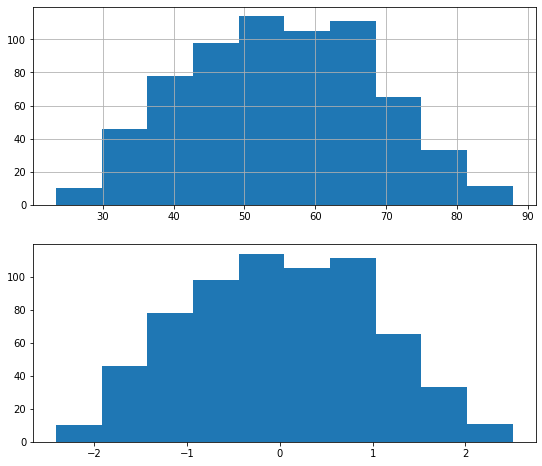

In [7]:
from sklearn.preprocessing import scale

# Standardize the train and test features
scaled_train_features = scale(train_features)
scaled_test_features = scale(test_features)

# Plot histograms of the 14-day SMA RSI before and after scaling
f, ax = plt.subplots(nrows=2, ncols=1)
train_features.iloc[:, 2].hist(ax=ax[0])
ax[1].hist(scaled_train_features[:, 2])
plt.show()

# Optimize n_neighbors

Now that we have scaled data, we can try using a KNN model. To maximize performance, we should tune our model's hyperparameters. 

In [8]:
from sklearn.neighbors import KNeighborsRegressor

for n in range(2,23):
    # Create and fit the KNN model
    knn = KNeighborsRegressor(n_neighbors=n)
    
    # Fit the model to the training data
    knn.fit(scaled_train_features, train_targets)
    
    # Print number of neighbors and the score to find the best value of n
    print("n_neighbors =", n)
    print('train, test scores')
    print(knn.score(scaled_train_features, train_targets))
    print(knn.score(scaled_test_features, test_targets))
    print()  # prints a blank line

n_neighbors = 2
train, test scores
0.7263568783973707
-0.6895403638783411

n_neighbors = 3
train, test scores
0.6072429006243716
-0.6506936839844994

n_neighbors = 4
train, test scores
0.5286824460245365
-0.6042740067646624

n_neighbors = 5
train, test scores
0.47121161898176833
-0.48376781843817573

n_neighbors = 6
train, test scores
0.4428891977704068
-0.44117664403290724

n_neighbors = 7
train, test scores
0.41223414388097224
-0.39912811193277653

n_neighbors = 8
train, test scores
0.3807427540267774
-0.36411211351254225

n_neighbors = 9
train, test scores
0.35626651921350405
-0.32396175465516763

n_neighbors = 10
train, test scores
0.35009028681819077
-0.30391872403365827

n_neighbors = 11
train, test scores
0.3392663859481717
-0.28249856644583504

n_neighbors = 12
train, test scores
0.3154386817491821
-0.26197468987374206

n_neighbors = 13
train, test scores
0.3024224041178276
-0.2625998097556963

n_neighbors = 14
train, test scores
0.2933993572401393
-0.21451694003800603

n_neigh

# Evaluate KNN performance

We just saw a few things with our KNN scores. For one, the training scores started high and decreased with increasing n, which is typical. The test set performance reached a peak at 5 though, and we will use that as our setting in the final KNN model.

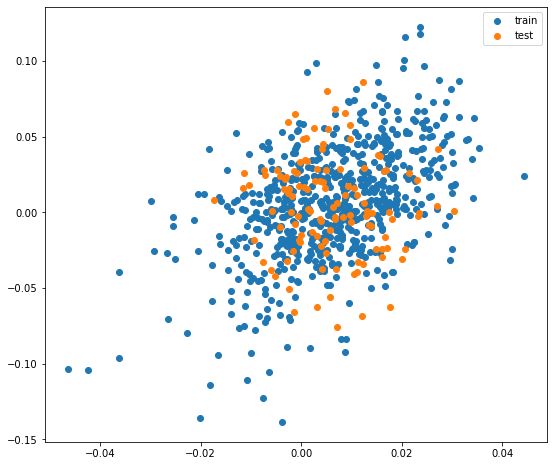

In [9]:
# Create the model with the best-performing n_neighbors of 5
knn = KNeighborsRegressor(n_neighbors=21)

# Fit the model
knn.fit(scaled_train_features, train_targets)

# Get predictions for train and test sets
train_predictions = knn.predict(scaled_train_features)
test_predictions = knn.predict(scaled_test_features)

# Plot the actual vs predicted values
plt.scatter(train_predictions, train_targets, label='train')
plt.scatter(test_predictions, test_targets, label='test')
plt.legend()
plt.show()

# Build and fit a simple neural net

The next model we will learn how to use is a neural network. Neural nets can capture complex interactions between variables, but are difficult to set up and understand. Recently, they have been beating human experts in many fields, including image recognition and gaming (check out AlphaGo) -- so they have great potential to perform well.

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [11]:
# Create the model
model_1 = Sequential()
model_1.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_1.add(Dense(20, activation='relu'))
model_1.add(Dense(1, activation='linear'))

# Fit the model
model_1.compile(optimizer='adam', loss='mse')
history = model_1.fit(scaled_train_features, train_targets, epochs=25)

Epoch 1/25
21/21 [==============================] - 0s 882us/step - loss: 0.0269
Epoch 2/25
21/21 [==============================] - 0s 848us/step - loss: 0.0062
Epoch 3/25
21/21 [==============================] - 0s 825us/step - loss: 0.0031
Epoch 4/25
21/21 [==============================] - 0s 906us/step - loss: 0.0024
Epoch 5/25
21/21 [==============================] - 0s 861us/step - loss: 0.0020
Epoch 6/25
21/21 [==============================] - 0s 859us/step - loss: 0.0019
Epoch 7/25
21/21 [==============================] - 0s 761us/step - loss: 0.0016
Epoch 8/25
21/21 [==============================] - 0s 753us/step - loss: 0.0015
Epoch 9/25
21/21 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 10/25
21/21 [==============================] - 0s 873us/step - loss: 0.0013
Epoch 11/25
21/21 [==============================] - 0s 859us/step - loss: 0.0012
Epoch 12/25
21/21 [==============================] - 0s 739us/step - loss: 0.0012
Epoch 13/25
21/21 [========

# Plot losses

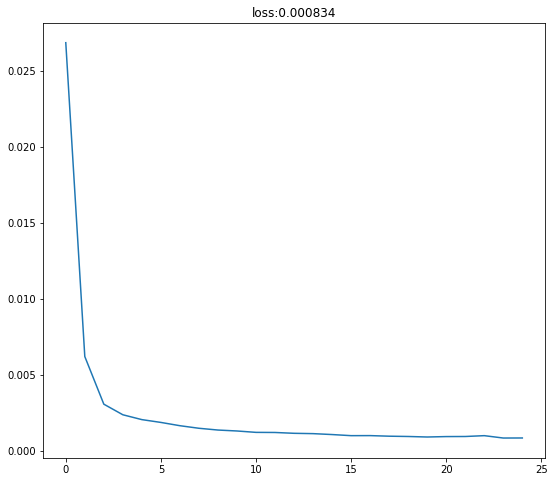

In [12]:
# Plot the losses from the fit
plt.plot(history.history['loss'])

# Use the last loss as the title
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

# Measure performance

0.41499043107346634
-0.9645223009606683


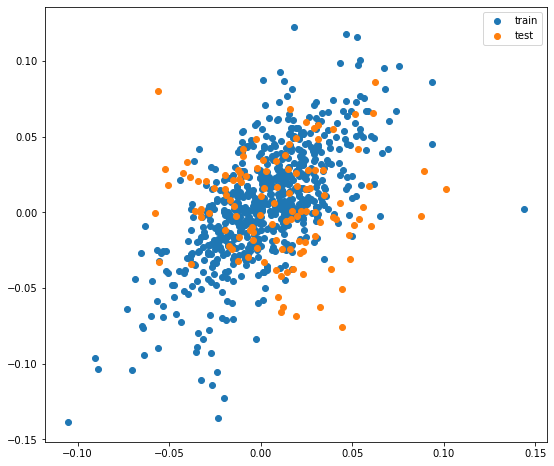

In [13]:
from sklearn.metrics import r2_score

# Calculate R^2 score
train_preds = model_1.predict(scaled_train_features)
test_preds = model_1.predict(scaled_test_features)
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Plot predictions vs actual
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')
plt.legend()
plt.show()